In [29]:
%load_ext autoreload
%autoreload 2

import os
import json
from collections import Counter
import numpy as np
from parlai_internal.projects.seq2plan2seq.controlled_seq2seq.control_vars import CONTROL2NUMBUCKETS, CONTROL2CONTINUOUS
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict
from parlai_internal.projects.seq2plan2seq.controlled_seq2seq.beamsearch_features import eval_attr, ATTR2SENTSCOREFN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
models_dirs = ['/private/home/abisee/models']
baseline = "seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2"
mf2wordstats = {}

for models_dir in models_dirs:
    wordstat_files = [fname for fname in os.listdir(models_dir) if 'wordstats.json' in fname]
    for json_file in sorted(wordstat_files):
        if "controlled_seq2seq" not in json_file and "goldresponse" not in json_file and baseline not in json_file:
            continue
        mf = json_file[:json_file.index('.wordstats.json')]
        print(mf)
        with open(os.path.join(models_dir, json_file), "r") as f:
            data = json.load(f)
        mf2wordstats[mf] = data
        
for mf, wordstats in mf2wordstats.items():
    d = defaultdict(int)
    for k,v in wordstats['word_statistics']['freqs_cnt'].items():
        d[k] = v
    wordstats['word_statistics']['freqs_cnt'] = d
    

controlled_seq2seq_contuserword20.valid.beam1.beamminnbest30.setcontrols:contuserwordNone
controlled_seq2seq_contuserword20.valid.beam20.beamminnbest30.setcontrols:contuserwordNone
controlled_seq2seq_contuserword20_niwf10buckets10.valid.beam1.beamminnbest30.setcontrols:contuserwordNone_niwf_10bucketsNone
controlled_seq2seq_contuserword20_niwf10buckets10.valid.beam20.beamminnbest30setcontrols:contuserwordNone_niwf_10bucketsNone
controlled_seq2seq_niwf10buckets10.valid.beam1.beamminnbest30.setcontrols:niwf_10bucketsNone
controlled_seq2seq_niwf10buckets10.valid.beam20.beamminnbest30.setcontrols:niwf_10bucketsNone
controlled_seq2seq_question10.valid.beam1.beamminnbest30.setcontrols:questionNone
controlled_seq2seq_question10.valid.beam20.beamminnbest30.setcontrols:questionNone
controlled_seq2seq_question10_contuserword20.valid.beam1.beamminnbest30.setcontrols:contuserwordNone_questionNone
controlled_seq2seq_question10_contuserword20.valid.beam20.beamminnbest30setcontrols:contuserwordNone_qu

In [31]:
from IPython.display import HTML, display
import tabulate

def mean(l):
    return sum(l)/len(l)

def model2row(mf, wordstats):
#     avg_niwf = wordstats['niwf']['avg_niwf']*100
    mean_wlength = mean(wordstats['word_statistics']['mean_wlength'])
    mean_clength = mean(wordstats['word_statistics']['mean_clength'])
    row = [
        mf,
        wordstats['report']['exs'],
        wordstats['report']['ppl'],
        "%.2f%%" % wordstats['unique_percent'],
        "%.2f" % mean_wlength,
        "%.2f" % mean_clength,
#         "%.4f%%" % avg_niwf,
        "%i" % wordstats['word_statistics']['freqs_cnt']['100'],
        "%i" % wordstats['word_statistics']['freqs_cnt']['1000'],
        "%i" % wordstats['word_statistics']['freqs_cnt']['10000'],
#         "%.4f" % wordstats['distinct-n']['1'],
#         "%.4f" % wordstats['distinct-n']['2'],
#         "%.4f" % wordstats['distinct-n']['3'],
#         "%.4f" % wordstats['distinct-n']['4'],
    ]
    
    for attr in sorted(ATTR2SENTSCOREFN.keys()):
        if 'output_attribute_stats' in wordstats:
            stats = wordstats['output_attribute_stats']
            if attr in stats:
                m = mean(stats[attr])
                row.append("%.2f%%" % (m*100))
                continue
        row.append('')
                
    
    for control, num_buckets in CONTROL2NUMBUCKETS.items():
        if control in wordstats['faithfulness_stats']['confusion_matrices']:
            conf_matrix = np.array(wordstats['faithfulness_stats']['confusion_matrices'][control])
            for b in range(num_buckets):
                acc = conf_matrix[b, b] / np.sum(conf_matrix[b, :])
                row.append("%.2f%%" % (acc*100))
        else:
            row += ['']*num_buckets
        
    return row

header_row = ['model name', 
              'num_exs', 
              'ppl',
              'unique_perc', 
              'mean_wlength', 
              'mean_clength',
#               'avg_niwf',
              '# rare<100', 
              '# rare<1000', 
              '# rare<10000',
#               'distinct-1',
#               'distinct-2',
#               'distinct-3',
#               'distinct-4',
             ] 

for attr in sorted(ATTR2SENTSCOREFN.keys()):
    header_row.append(attr)
    
for control, num_buckets in CONTROL2NUMBUCKETS.items():
    for b in range(num_buckets):
        header_row.append('%s bucket %i acc' % (control, b))

table = [header_row] 

def include_model(mf):
    if "goldresponse" in mf:
        return True
    if "usemodelreply" in mf:
        return True
    return False

for mf in sorted(mf2wordstats.keys()):
    stat = mf2wordstats[mf]
    if include_model(mf):
        table.append(model2row(mf, mf2wordstats[mf]))
    

html = HTML(tabulate.tabulate(table, tablefmt='html', stralign='center'))
html.data = html.data.replace("text-align: center;", "text-align: left;") # fix left-alignment 
display(html)

model name,num_exs,ppl,unique_perc,mean_wlength,mean_clength,# rare<100,# rare<1000,# rare<10000,extrep_rep2gram,extrep_rep3gram,extrep_repnonstopword,extrep_repword,intrep_rep2gram,intrep_rep3gram,intrep_repnonstopword,intrep_repword,spec_avgniwf,spec_maxniwf,question bucket 0 acc,question bucket 1 acc,niwf_10buckets bucket 0 acc,niwf_10buckets bucket 1 acc,niwf_10buckets bucket 2 acc,niwf_10buckets bucket 3 acc,niwf_10buckets bucket 4 acc,niwf_10buckets bucket 5 acc,niwf_10buckets bucket 6 acc,niwf_10buckets bucket 7 acc,niwf_10buckets bucket 8 acc,niwf_10buckets bucket 9 acc,contuserword bucket 0 acc,contuserword bucket 1 acc
goldresponse,7801,0.0,98.77%,11.87,51.22,630,3636,11218,4.65%,1.07%,9.62%,31.02%,0.38%,0.05%,0.97%,5.86%,1.40%,11.73%,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam1,7801,25.7,63.41%,10.65,38.62,256,1884,7615,37.85%,27.44%,37.25%,58.67%,9.70%,6.45%,11.57%,20.81%,0.29%,1.96%,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest1,7801,26.88,15.04%,7.13,27.63,18,393,2513,46.73%,42.89%,44.14%,61.39%,0.51%,0.38%,0.67%,3.32%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20,7801,26.52,15.13%,7.47,28.78,16,370,2632,47.26%,43.30%,44.38%,62.42%,0.58%,0.44%,0.75%,3.74%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:extrep_2gramusedbefore-1.0,7801,25.87,28.24%,7.53,29.51,21,546,3884,6.29%,0.84%,6.01%,38.07%,0.43%,0.28%,0.76%,3.17%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:extrep_3gramusedbefore-1.0,7801,25.91,25.30%,7.56,29.34,19,476,3749,12.08%,2.40%,9.16%,43.07%,0.36%,0.23%,0.74%,3.27%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:extrep_nonstopwordusedbefore-1.0,7801,26.33,18.29%,7.41,28.33,17,370,2584,36.36%,30.97%,28.85%,55.83%,0.39%,0.29%,0.51%,3.72%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:extrep_wordusedbefore-1.0,7801,25.99,31.98%,7.22,28.72,36,653,4241,6.47%,2.81%,4.68%,28.13%,0.85%,0.66%,1.09%,3.19%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:spec_iwf1.0.numex64,64,16.87,34.38%,8.14,29.33,0,3,19,0.00%,0.00%,0.00%,0.00%,0.10%,0.00%,0.52%,2.83%,,,,,,,,,,,,,,,,
seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.usemodelreply.beam20.beamminnbest20.beamfeatures:spec_niwf1.0.numex64,64,16.87,34.38%,8.14,29.33,0,3,19,0.00%,0.00%,0.00%,0.00%,0.10%,0.00%,0.52%,2.83%,0.16%,1.40%,,,,,,,,,,,,,,


In [ ]:
# plot distribution of continuous control vars

control = "niwf_10buckets"
num_buckets = CONTROL2NUMBUCKETS[control]


# BUCKET BAR CHART
figure(figsize=(16, 10))
x = np.array([b for b in range(num_buckets)])
bar_width = 0.1
opacity = 0.8
plotted_target = True
num_plotted = 0


for mf in sorted(mf2wordstats.keys()):
    if mf=='goldresponse':
        continue
    if "beam20" not in mf:
        continue
    if "niwf" not in mf:
        continue
    wordstats = mf2wordstats[mf]
    continuous_values = wordstats['faithfulness_stats']['continuous_values']

    if control not in continuous_values.keys():
        continue
        
    # these are both dicts from bucketid to list of floats
    cont_vals_model = continuous_values[control]['model']
    cont_vals_target = continuous_values[control]['target']
    cont_vals_model = {int(k):v for k,v in cont_vals_model.items()}
    cont_vals_target = {int(k):v for k,v in cont_vals_target.items()}

    y_model = [mean(cont_vals_model[b]) for b in range(num_buckets)]
    y_target = [-1/mean(np.log(cont_vals_target[b])) for b in range(num_buckets)]
    rects1 = plt.bar(x + bar_width*num_plotted, y_model, bar_width,
                     alpha=opacity,
#                      color='r',
                     label=mf)
    num_plotted += 1
    if not plotted_target:
        rects2 = plt.bar(x + bar_width*num_plotted, y_target, bar_width,
                 alpha=opacity,
#                  color='g',
                 label='target')
        plotted_target = True
        num_plotted += 1
    plt.xlabel("%s buckets" % control)
    plt.ylabel("%s mean value" % control)
    plt.title("Controlling %s in %s" % (control, mf))
    plt.legend(loc='upper left')

    
    
plt.show()

/private/home/abisee/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


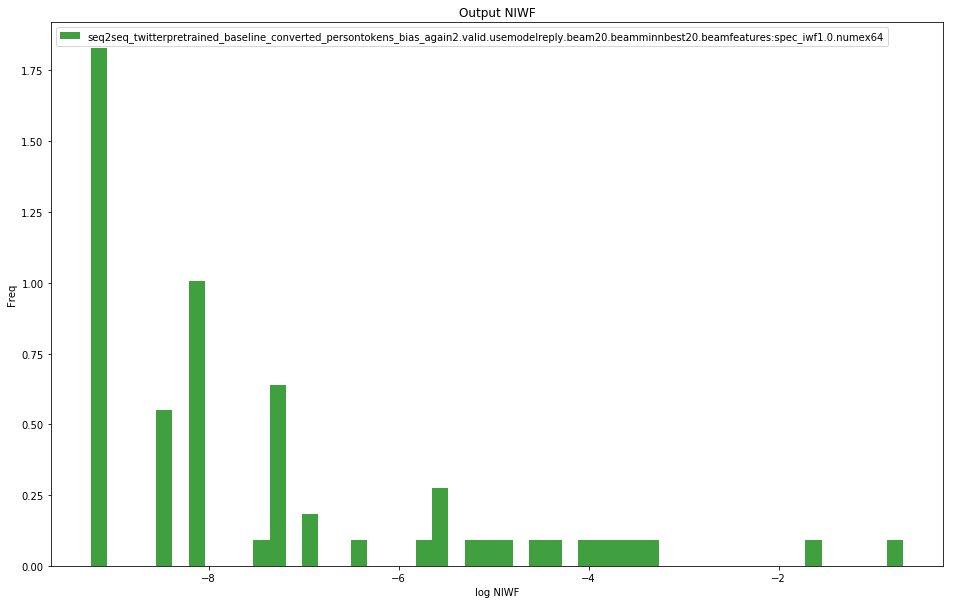

In [25]:
# plot distribution of niwf output attribute

# HISTOGRAM
figure(figsize=(16, 10))
num_plotted = 0


for mf in sorted(mf2wordstats.keys()):
    wordstats = mf2wordstats[mf]
    if 'output_attribute_stats' not in wordstats:
        continue
    if 'spec_niwf' not in wordstats['output_attribute_stats']:
        continue
    niwf_values = wordstats['output_attribute_stats']['spec_niwf'] # list of floats
    niwf_values = np.log(niwf_values)
    

    n, bins, patches = plt.hist(niwf_values, 50, normed=1, facecolor='green', alpha=0.75, label=mf)
    num_plotted += 1

    plt.xlabel("log NIWF")
    plt.ylabel("Freq")
    plt.title("Output NIWF")
    plt.legend(loc='upper left')

    
    
plt.show()

In [99]:
print(mf2wordstats['goldresponse'].keys())
print(mf2wordstats['throwaway.valid.beam1.beamminnbest3.setcontrols:contuserwordNone_niwf_10bucketsNone_questionNone']['faithfulness_stats'].keys())


dict_keys(['opt', 'unique_percent', 'word_statistics', 'predictions', 'report', 'faithfulness_stats'])
dict_keys(['contuserword', 'niwf_10buckets', 'question'])


In [7]:
def show_preds(mf):
    counter = Counter()
    preds = mf2wordstats[mf]['predictions']
    counter.update(preds)
    num_unique = len([p for p,count in counter.items() if count==1])
    print("num_unique: ", num_unique, num_unique*100/sum(counter.values()))
    for p, count in counter.most_common(100):
        print("%3i   %s" % (count, p))

In [10]:
show_preds('seq2seq_twitterpretrained_baseline_converted_persontokens_bias_again2.valid.beam20.beamminnbest20.beamfeatures:intrep_wordusedbefore-1.0')

num_unique:  2278 29.201384437892578
1461   what do you do for a living ?
346   do you have any hobbies ?
295   do you have any pets ?
234   what kind of music do you like ?
227   i am good . how are you ?
133   that sounds like a lot of fun .
 99   hi how are you today ?
 69   i am sorry to hear that .
 59   do you have any kids ?
 52   what kind of food do you like ?
 47   what kind of music do you play ?
 45   what kind of work do you do ?
 44   what kind of dog do you have ?
 43   i am good how are you ?
 43   what kind of car do you have ?
 42   that sounds like a lot of fun
 41   what city are you from ?
 39   what is your favorite color ?
 38   what kind of dogs do you have ?
 37   i am doing well . how about you ?
 33   i am good thanks for asking
 30   what do you like to do for fun ?
 30   what kind of car do you drive ?
 28   do you have any siblings ?
 27   do you play any instruments ?
 26   hi how are you today
 26   i'm good . how are you ?
 25   i love red , reminds me 

In [ ]:
#         # BUCKET SCATTER PLOT
#         x = []
#         for b in range(num_buckets):
#             assert len(cont_vals_model[b]) == len(cont_vals_target[b])
#             x += [b] * len(cont_vals_model[b])
            
#         y_model = []
#         for b in range(num_buckets):
#             y_model += cont_vals_model[b]
#         y_model = np.log(y_model)
            
#         y_target = []
#         for b in range(num_buckets):
#             y_target += cont_vals_target[b]
#         y_target = np.log(y_target)
#         figure(figsize=(10, 6))
#         plt.scatter(x, y_model, c="r", alpha=0.5, label="model")
#         plt.scatter(x, y_target, c="g", alpha=0.5, label="target")
#         plt.xlabel("%s Buckets" % control)
#         plt.ylabel("%s Continuous values" % control)
#         plt.title("Controlling %s in %s" % (control, mf))
#         plt.legend(loc='upper left')
#         plt.show()
        
#         x = []
#         y = []
#         for b in range(num_buckets):
#             x += cont_vals_target[b]
#             y += cont_vals_model[b]
#         x = np.log(x)
#         y = np.log(y)
            
            
#         # CONTINUOUS SCATTER PLOT
#         figure(figsize=(10, 6))
#         plt.scatter(x, y, c="b", alpha=0.5)
#         plt.xlabel("target %s" % control)
#         plt.ylabel("model %s" % control)
#         plt.title("Controlling %s in %s" % (control, mf))
#         plt.plot([-8, 0], [-8, 0], 'k-')
#         plt.show()